In [1]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [2]:
df = pd.read_csv('train.csv')
df.shape

(158314, 2)

In [3]:
df.head()

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


# Preprocessing

We have two columns:
* `raw_character_text`: the character who speaks
* `spoken_words`: the raw text from the line of dialogue

In [4]:
df.isnull().sum()

raw_character_text    17814
spoken_words          26459
dtype: int64

The missing values comes from the part of the script where something happens, but with no dialogue. For instance "(Springfield Elementary School: EXT. ELEMENTARY - SCHOOL PLAYGROUND - AFTERNOON)"

Removing the missing values:

In [5]:
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

raw_character_text    0
spoken_words          0
dtype: int64

## Cleaning:
We are lemmatizing and removing the stopwords and non-alphabetic characters for each line of dialogue.

In [8]:
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

Removes non-alphabetic characters:

In [9]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['spoken_words'])

Taking advantage of spaCy .pipe() attribute to speed-up the cleaning process:

In [11]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_process=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 1.44 mins


Put the results in a DataFrame to remove missing values and duplicates:

In [12]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(85955, 1)

## Bigrams:
We are using Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences.
https://radimrehurek.com/gensim/models/phrases.html

The main reason we do this is to catch words like "mr_burns" or "bart_simpson" !

In [13]:
from gensim.models.phrases import Phrases, Phraser

As `Phrases()` takes a list of list of words as input:

In [14]:
sent = [row.split() for row in df_clean['clean']]

Creates the relevant phrases from the list of sentences:

In [15]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

INFO - 09:38:10: collecting all words and their counts
INFO - 09:38:10: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 09:38:10: PROGRESS: at sentence #10000, processed 63557 words and 52687 word types
INFO - 09:38:10: PROGRESS: at sentence #20000, processed 130936 words and 99557 word types
INFO - 09:38:10: PROGRESS: at sentence #30000, processed 192963 words and 138094 word types
INFO - 09:38:10: PROGRESS: at sentence #40000, processed 249832 words and 172088 word types
INFO - 09:38:10: PROGRESS: at sentence #50000, processed 311270 words and 207883 word types
INFO - 09:38:10: PROGRESS: at sentence #60000, processed 373576 words and 242881 word types
INFO - 09:38:10: PROGRESS: at sentence #70000, processed 436425 words and 277780 word types
INFO - 09:38:10: PROGRESS: at sentence #80000, processed 497889 words and 310841 word types
INFO - 09:38:10: collected 329545 token types (unigram + bigrams) from a corpus of 537097 words and 85955 sentences
INFO - 09:38:10: m

**The goal of Phraser() is to cut down memory consumption of Phrases()**, by discarding model state not strictly needed for the bigram detection task:

In [16]:
bigram = Phraser(phrases)

INFO - 09:38:19: exporting phrases from Phrases<329545 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 09:38:19: FrozenPhrases lifecycle event {'msg': 'exported FrozenPhrases<125 phrases, min_count=30, threshold=10.0> from Phrases<329545 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000> in 0.49s', 'datetime': '2023-04-01T09:38:19.806168', 'gensim': '4.1.2', 'python': '3.9.12 (main, Apr  5 2022, 01:53:17) \n[Clang 12.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


Transform the corpus based on the bigrams detected:

In [17]:
sentences = bigram[sent]

## Most Frequent Words:
Mainly a sanity check of the effectiveness of the lemmatization, removal of stopwords, and addition of bigrams.

In [18]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

29643

In [19]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['oh', 'like', 'know', 'get', 'hey', 'think', 'come', 'right', 'look', 'want']

# Training the model
## Gensim Word2Vec Implementation:
We use Gensim implementation of word2vec: https://radimrehurek.com/gensim/models/word2vec.html

In [20]:
import multiprocessing

from gensim.models import Word2Vec

## training of the model in 3 steps:

1. `Word2Vec()`: 
>In this first step, I set up the parameters of the model one-by-one. <br>I do not supply the parameter `sentences`, and therefore leave the model uninitialized, purposefully.
2. `.build_vocab()`: 
>Here it **builds the vocabulary from a sequence of sentences** and thus initialized the model. <br>With the loggings, I can follow the progress and even more important, the effect of `min_count` and `sample` on the word corpus. I noticed that these two parameters, and in particular `sample`, have a great influence over the performance of a model. Displaying both allows for a more accurate and an easier management of their influence.
3. `.train()`:
>Finally, trains the model.<br>
The loggings here are mainly useful for monitoring, making sure that no threads are executed instantaneously.

In [21]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

## The parameters:

* `min_count` <font color='purple'>=</font> <font color='green'>int</font> - Ignores all words with total absolute frequency lower than this - (2, 100)


* `window` <font color='purple'>=</font> <font color='green'>int</font> - The maximum distance between the current and predicted word within a sentence. E.g. `window` words on the left and `window` words on the left of our target - (2, 10)


* `vector_size` <font color='purple'>=</font> <font color='green'>int</font> - Dimensionality of the feature vectors. - (50, 300)


* `sample` <font color='purple'>=</font> <font color='green'>float</font> - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial.  - (0, 1e-5)


* `alpha` <font color='purple'>=</font> <font color='green'>float</font> - The initial learning rate - (0.01, 0.05)


* `min_alpha` <font color='purple'>=</font> <font color='green'>float</font> - Learning rate will linearly drop to `min_alpha` as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00


* `negative` <font color='purple'>=</font> <font color='green'>int</font> - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)


* `workers` <font color='purple'>=</font> <font color='green'>int</font> - Use these many worker threads to train the model (=faster training with multicore machines)

In [24]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

INFO - 09:45:06: Word2Vec lifecycle event {'params': 'Word2Vec(vocab=0, vector_size=300, alpha=0.03)', 'datetime': '2023-04-01T09:45:06.364859', 'gensim': '4.1.2', 'python': '3.9.12 (main, Apr  5 2022, 01:53:17) \n[Clang 12.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


## Building the Vocabulary Table:
Word2Vec requires us to build the vocabulary table (simply digesting all the words and filtering out the unique words, and doing some basic counts on them):

In [25]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 09:45:30: collecting all words and their counts
INFO - 09:45:30: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 09:45:30: PROGRESS: at sentence #10000, processed 61712 words, keeping 9500 word types
INFO - 09:45:30: PROGRESS: at sentence #20000, processed 127347 words, keeping 14369 word types
INFO - 09:45:30: PROGRESS: at sentence #30000, processed 187813 words, keeping 17427 word types
INFO - 09:45:30: PROGRESS: at sentence #40000, processed 243323 words, keeping 20120 word types
INFO - 09:45:31: PROGRESS: at sentence #50000, processed 303187 words, keeping 22550 word types
INFO - 09:45:31: PROGRESS: at sentence #60000, processed 363926 words, keeping 24793 word types
INFO - 09:45:31: PROGRESS: at sentence #70000, processed 425391 words, keeping 26959 word types
INFO - 09:45:31: PROGRESS: at sentence #80000, processed 485525 words, keeping 28775 word types
INFO - 09:45:31: collected 29643 word types from a corpus of 523642 raw words and 85955 sentence

Time to build vocab: 0.01 mins


## Training of the model:
_Parameters of the training:_
* `total_examples` <font color='purple'>=</font> <font color='green'>int</font> - Count of sentences;
* `epochs` <font color='purple'>=</font> <font color='green'>int</font> - Number of iterations (epochs) over the corpus - [10, 20, 30]
* `w2v_model.corpus_count` = 85955

In [26]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 09:46:00: Word2Vec lifecycle event {'msg': 'training model with 7 workers on 3317 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2 shrink_windows=True', 'datetime': '2023-04-01T09:46:00.632880', 'gensim': '4.1.2', 'python': '3.9.12 (main, Apr  5 2022, 01:53:17) \n[Clang 12.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'train'}
INFO - 09:46:01: worker thread finished; awaiting finish of 6 more threads
INFO - 09:46:01: worker thread finished; awaiting finish of 5 more threads
INFO - 09:46:01: worker thread finished; awaiting finish of 4 more threads
INFO - 09:46:01: worker thread finished; awaiting finish of 3 more threads
INFO - 09:46:01: worker thread finished; awaiting finish of 2 more threads
INFO - 09:46:01: worker thread finished; awaiting finish of 1 more threads
INFO - 09:46:01: worker thread finished; awaiting finish of 0 more threads
INFO - 09:46:01: EPOCH - 1 : training on 523642 raw words (199074 effective words) took 0.8s,

Time to train the model: 0.36 mins


As we do not plan to train the model any further, we are calling init_sims(), which will make the model much more memory-efficient:

>After running Word2Vec.init_sims(replace=True)

Note that you cannot continue training after doing a replace. The model becomes effectively read-only = you can call most_similar, similarity etc., but not train.

In [30]:
w2v_model.init_sims(replace=True)

/var/folders/q_/sg2ykfgs57z4jr3mr195l43c0000gn/T/ipykernel_9199/514372312.py:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)
WARNING - 09:50:55: destructive init_sims(replace=True) deprecated & no longer required for space-efficiency


# Exploring the model
Here, we will ask our model to find the word most similar to some of the most iconic characters of the Simpsons!

In [31]:
w2v_model.wv.most_similar(positive=["homer"])

[('crummy', 0.7341076731681824),
 ('marge', 0.718590259552002),
 ('sweetheart', 0.7124089002609253),
 ('snuggle', 0.7022238969802856),
 ('gee', 0.6937745213508606),
 ('depressed', 0.6823862791061401),
 ('bongo', 0.6800528764724731),
 ('creepy', 0.6685090661048889),
 ('shoulda', 0.6676127314567566),
 ('tell', 0.6674078106880188)]

_A small precision here:_<br>
The dataset is the Simpsons' lines of dialogue; therefore, when we look at the most similar words from "homer" we do **not** necessary get his family members, personality traits, or even his most quotable words. No, we get what other characters (as Homer does not often refers to himself at the 3rd person) said along with "homer", such as how he feels or looks ("depressed"), where he is ("hammock"), or with whom ("marge").

Let's see what the bigram "homer_simpson" gives us by comparison:

In [32]:
w2v_model.wv.most_similar(positive=["homer_simpson"])

[('select', 0.6877285838127136),
 ('pleased', 0.6750539541244507),
 ('elect', 0.6669206023216248),
 ('council', 0.6664687991142273),
 ('congratulation', 0.6460558176040649),
 ('versus', 0.6447033882141113),
 ('easily', 0.636868417263031),
 ('kennedy', 0.634407639503479),
 ('charles', 0.6310305595397949),
 ('robert', 0.6273319721221924)]

In [33]:
w2v_model.wv.most_similar(positive=["marge"])

[('brunch', 0.7189982533454895),
 ('homer', 0.718590259552002),
 ('homie', 0.7177544832229614),
 ('snuggle', 0.7148074507713318),
 ('attract', 0.7130388617515564),
 ('crummy', 0.6997184157371521),
 ('badly', 0.6915509700775146),
 ('sorry', 0.6901881098747253),
 ('eliza', 0.6870733499526978),
 ('patty_selma', 0.6865948438644409)]

In [34]:
w2v_model.wv.most_similar(positive=["bart"])

[('lisa', 0.8095225691795349),
 ('hearing', 0.7413356304168701),
 ('mom', 0.7230429649353027),
 ('dr_hibbert', 0.721238374710083),
 ('mom_dad', 0.712069571018219),
 ('convince', 0.7078627943992615),
 ('jealous', 0.6956207156181335),
 ('milhouse', 0.688723623752594),
 ('bedtime', 0.6855090856552124),
 ('homework', 0.6849009990692139)]

## Similarities:
Here, we will see how similar are two words to each other :

In [38]:
w2v_model.wv.similarity('maggie', 'baby')

0.7124994

Maggie is indeed the most renown baby in the Simpsons!

In [39]:
w2v_model.wv.similarity('bart', 'nelson')

0.5243031

Bart and Nelson, though friends, are not that close, makes sense!

## Odd-One-Out:

Here, we ask our model to give us the word that does not belong to the list!

Between Jimbo, Milhouse, and Kearney, who is the one who is not a bully?

In [40]:
w2v_model.wv.doesnt_match(['jimbo', 'milhouse', 'kearney'])

WARNING - 09:55:35: vectors for words {'kearney'} are not present in the model, ignoring these words


'jimbo'

What if we compared the friendship between Nelson, Bart, and Milhouse?

In [41]:
w2v_model.wv.doesnt_match(["nelson", "bart", "milhouse"])

'nelson'

Seems like Nelson is the odd one here!

Last but not least, how is the relationship between Homer and his two sister-in-laws?

In [42]:
w2v_model.wv.doesnt_match(['homer', 'patty', 'selma'])

'homer'

Damn, they really do not like you Homer!

## Analogy difference:
Which word is to woman as homer is to marge?

In [43]:
w2v_model.wv.most_similar(positive=["woman", "homer"], negative=["marge"], topn=3)

[('man', 0.5898147821426392),
 ('wonder', 0.5552454590797424),
 ('married', 0.554778516292572)]

"man" comes at the first position, that looks about right!

Which word is to woman as bart is to man?

In [44]:
w2v_model.wv.most_similar(positive=["woman", "bart"], negative=["man"], topn=3)

[('lisa', 0.71198570728302),
 ('parent', 0.625899076461792),
 ('mom', 0.6202954053878784)]

### t-SNE visualizations:
t-SNE is a non-linear dimensionality reduction algorithm that attempts to represent high-dimensional data and the underlying relationships between vectors in a lower-dimensional space.<br>
Here is a good tutorial on it: https://towardsdatascience.com/what-why-and-how-of-t-sne-1f78d13e224d

In [46]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import warnings
warnings.simplefilter("ignore")

Our goal in this section is to plot our 300 dimensions vectors into 2 dimensional graphs, and see if we can spot interesting patterns.<br>
For that we are going to use t-SNE implementation from scikit-learn.

To make the visualizations more relevant, we will look at the relationships between a query word (in <font color='red'>**red**</font>), its most similar words in the model (in <font color="blue">**blue**</font>), and other words from the vocabulary (in <font color='green'>**green**</font>).

In [50]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']
    
    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=19).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

Code inspired by: [[2]](#References:)

## 10 Most similar words vs. 8 Random words:
Let's compare where the vector representation of Homer, his 10 most similar words from the model, as well as 8 random ones, lies in a 2D graph:

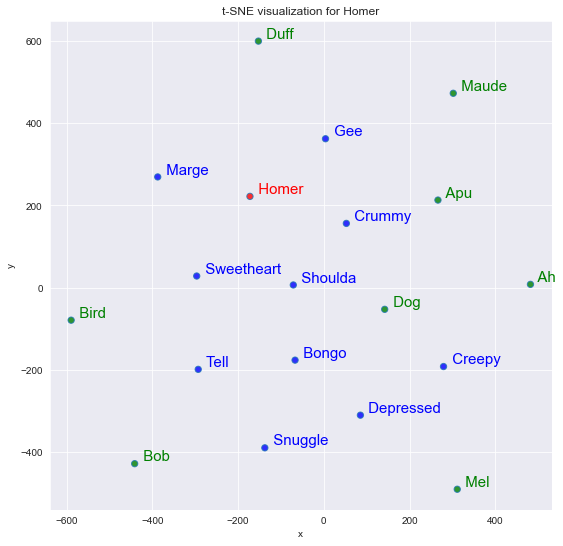

In [51]:
tsnescatterplot(w2v_model, 'homer', ['dog', 'bird', 'ah', 'maude', 'bob', 'mel', 'apu', 'duff'])

Interestingly, the 10 most similar words to Homer ends up around him, so does Apu and (sideshow) Bob, two recurrent characters.

## 10 Most similar words vs. 10 Most dissimilar

This time, let's compare where the vector representation of Maggie and her 10 most similar words from the model lies compare to the vector representation of the 10 most dissimilar words to Maggie:

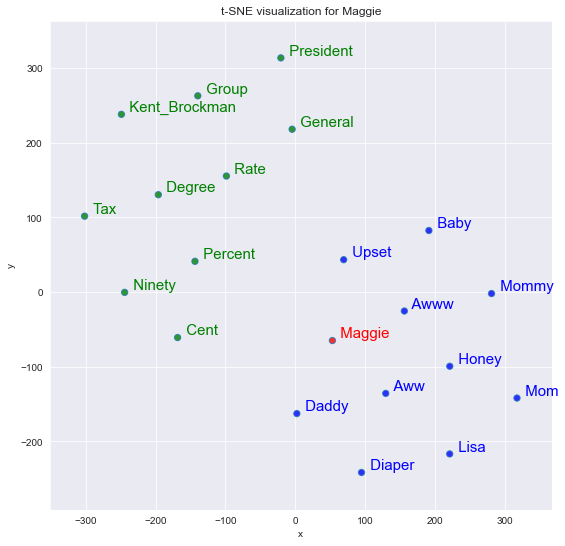

In [52]:
tsnescatterplot(w2v_model, 'maggie', [i[0] for i in w2v_model.wv.most_similar(negative=["maggie"])])

Neat! Maggie and her most similar words form a distinctive cluster from the most dissimilar words, it is a really encouraging plot!

Credits to Pierre Megret

### Materials for more in depths understanding:
* Word Embeddings introduction: https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/
* Word2Vec introduction: https://skymind.ai/wiki/word2vec
* Another Word2Vec introduction: http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
* A great Gensim implentation tutorial: http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W467ScBjM2x
* Original articles from Mikolov et al.: https://arxiv.org/abs/1301.3781 and https://arxiv.org/abs/1310.4546


# References:
* [1]. Neural Net picture: McCormick, C. (2016, April 19). Word2Vec Tutorial - The Skip-Gram Model. Retrieved from http://www.mccormickml.com
* [2]. Aneesha Bakharia Medium article: https://medium.com/@aneesha/using-tsne-to-plot-a-subset-of-similar-words-from-word2vec-bb8eeaea6229

<center><strong>. . . The End . . .</strong></center>